In [7]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.collections import PathCollection

In [2]:
pth = os.path.join('..', '..')
pth_in = os.path.join(pth, 'data', 'modeling', 'landscape')
pth_out = os.path.join(pth, 'figures', 'cancer', 'CCCA', 'expression')

In [3]:
adata_plt = sc.read_h5ad(os.path.join(pth_in, 'development.h5ad'))
adata = sc.read_h5ad(os.path.join(pth_in, 'CCCA.h5ad')); adata

AnnData object with n_obs × n_vars = 8460 × 856
    obs: 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'ebv', 'celltype', 'Title', 'Category', 'Disease', 'Technology', 'Samples', 'Cells ', 'Name', 'patient', 'cell_subtype', 'source', 'disease', 'p16_status', 'site', 't_stage', 'n_stage', 'gender', 'race', 'age', 'tobacco_use', 'alcohol_use', 'hpv', 'hpv_score', 'treatment', 'procedure', 'sorting', 'cluster', 'malignant', 'sample_id', 'cell_subtype_clusters', 'tnm_stage', 'viral', 'location', 'cancer_type', 'treatment_exposure', 'treatment_response', 'cell_lineage', 'type', 'clusters_by_authors', 'cell_QCpass', 'is_tumor', 'cell_compartment', 'cluster_assignment', 'metastasis', 'sex', 'prior_enzalutamide', 'prior_abiraterone', 'prior_taxane', 'prior_platinum', 'prior_sipuleucel_T', 'purity', 'has_bulk_RNA', 'cancer_cell_state', 'PSA', 'source_region', 'gleason_score', 'ERG_status', 'cores',

In [4]:
# project: 3CA -> development (neighbors)
X_ref = adata_plt.obsm['X_mesen'].copy()
scale = np.ptp(X_ref, axis = 0)
X_3ca = adata.obsm['X_mesen'].copy()
X_ref = X_ref[np.newaxis, :, :] / scale
X_3ca = X_3ca[:, np.newaxis, :] / scale
d = np.linalg.norm(X_ref - X_3ca, axis = 2)
nbr = (d <= .1).astype(float).T
n_nbr = nbr.sum(axis = 1)

In [5]:
cmap, dims = 'Reds', ['X_mesen1', 'X_mesen2']

/tmp/ipykernel_2513329/3149200254.py:5: RuntimeWarning: invalid value encountered in divide
  adata_plt.obs[name] = nbr_sum / n_nbr


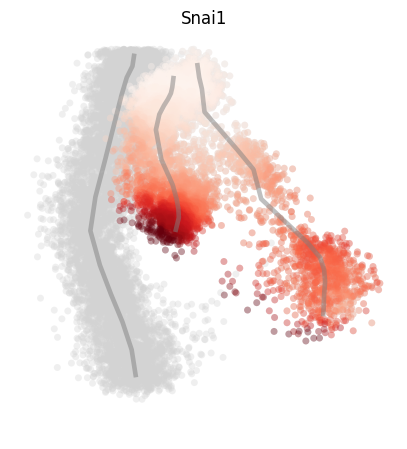

In [8]:
g, vmin, vmax = 'Snai1', 'p01', 'p99'
name = f'{g}_Average'
X_g = adata[:, g].X.toarray()
nbr_sum = np.squeeze(np.dot(nbr, X_g))
adata_plt.obs[name] = nbr_sum / n_nbr

# plot landscape
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.embedding(adata_plt, 'X_mesen', size = 100, alpha = .35,
                frameon = False, show = False, ax = ax)
sc.pl.embedding(adata_plt[adata_plt.obs.source != 'GSE162534'],
                'X_mesen', size = 100, alpha = .35,
                color = name, vmin = vmin, vmax = vmax,
                cmap = cmap, colorbar_loc = None,
                frameon = False, show = False, ax = ax)

# draw trajectories
for src, sdf in adata_plt.obs.groupby('source', observed = True):
    sdf['latent_z_bin'] = pd.qcut(sdf.latent_z, 13)
    sdf = sdf.groupby('latent_z_bin', observed = True)[dims].mean()
    ax.plot(sdf[dims[0]], sdf[dims[1]], lw = 3.33, color = 'gray', alpha = .5)

for coll in ax.collections:
    if isinstance(coll, PathCollection):
        coll.set_rasterized(True)

ax.invert_yaxis()
ax.set_title(g, size = 12)
ax.text(.5, -.05, ' ', ha = 'center',
        transform = ax.transAxes)
fn = os.path.join(pth_out, f'{g}.pdf')
plt.savefig(fn, dpi = 1200, bbox_inches = 'tight')

In [ ]:
# tf = ['', 'Snai2',
#       'Twist1', 'Zeb2',
#       'Prrx1', 'Prrx2',
#       'Foxc1', 'Foxc2']